GitHub: https://github.com/rohanneps/deakin/


Welcome to your assignment this week! 

To better understand the adverse use of AI, in this assignment, we will look at a Natural Language Processing use case.


Natural Language Pocessing (NLP) is a branch of Artificial Intelligence (AI) that helps computers to understand, to interpret and to manipulate natural (i.e. human) language.
Imagine NLP-powered machines as black boxes that are capable of understanding and evaluating the context of the input documents (i.e. collection of words), outputting meaningful results that depend on the task the machine is designed for.


![](imgs/1_3zMvUnPzYZF9CSHdj6hT5A.png)

<caption><center> Documents are fed into magic NLP model capable to get, for instance, the sentiment of the original content</center></caption>


In this notebook, you will implement a model that uses an LSTM to generate fake tweets and comments. You will also be able to try it to generate your own fake text. 

**You will learn to:**
- Apply an LSTM to generate fake comments.
- Generate your own fake text with deep learning.

Please run the following cell to load all the packages required in this assignment. This may take a few minutes. 


In [1]:
#!pip install numpy
#!pip install keras
#!pip install tensorflow

Run the following cell to load the packages you will need.

In [27]:
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.utils as ku 
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

tf.get_logger().setLevel('INFO')

# Build the model

Let's define a tokenizer and read the data from disk.

In [4]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('covid19_fake.txt').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ")

Now, let's splits the data into tweets  where each line of the input file is a fake tweets.

We also extract the vocabulary of the data.

In [5]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

You've loaded:
- `corpus`: an array where each entry is a fake post.
- `tokenizer`: which is the object that we will use to vectorize our dataset. This object also contains our word index.
- `total_words`: is the total number of words in the vacabulary.


In [6]:
print("Example of fake tweets: ",corpus[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

Example of fake tweets:  ['there is already a vaccine to treat covid19 . ', 'cleaning hands do not help to prevent covid19 . ']
Size of the vocabulary =  1257
Example of our word index =  [('.', 1), ('the', 2), ('covid19', 3), ('in', 4), ('to', 5), ('a', 6), ('of', 7), (',', 8), ('coronavirus', 9), ('and', 10)]


In [7]:
example = tokenizer.texts_to_sequences([corpus[0]])
example

[[48, 12, 278, 6, 49, 5, 133, 3, 1]]

The next step aims to generate the training set of n_grams sequences.

In [8]:
input_sequences = []
for line in corpus:
    # convert each document to list of tokens
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

You've create:
- `input_sequences`: which is a list of n_grams sequences.

In [9]:
sample = 20
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_word_map[i], end=' ')
                        

The entry  20  in 'input_sequences' is: 
[2, 3, 12, 187, 34, 188]
 and it corresponds to:
the covid19 is same as sars 

Next, we padd our training set to the max length in order to be able to make a batch processing.

In [10]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Run the following to see the containt of the padded 'input_sequences' object.

In [11]:
# reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_word_map:
        print(reverse_word_map[i], end=' ')
    else:
        print("__", end=' ')
print("]")
                

The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ the covid19 is same as sars ]


Given a sentence like **"the covid19 is same as "**, we want to design a model that can predict the next word -- in the case the word **"sars"**.

Therefore, the next code prepares our input and output to our model consequently.

In [12]:
# Assigning input and outputs to the model
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]

In [13]:
input_to_model.shape

(4030, 60)

In [14]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
, it corresponds to the following input to our model:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34]
 and the following output:  188


Finally, we convert our label to categorical labels for being processed by our model.

In [15]:
label = ku.to_categorical(label, num_classes=total_words)

In [16]:
np.argmax(label[sample]) # the index where there is a value should be 188 as shown by id label above

188

Here is the architecture of the model we will use:

![](imgs/text_generation.png)



 
**Task 1**: Implement `deep_fake_comment_model()`. You will need to carry out 5 steps:

1. Create a sequencial model using the `Sequential` class
2. Add an embedding layer to the model using the `Embedding` class of size 128
3. Add an LSTM layer to the model using the `LSTM` class of size 128
4. Add a Dense layer to the model using the `Dense` class with a `softmax` activation
5. Set a `categorical_crossentropy` loss function to the model and optimize `accuracy`.


In [18]:
#TASK 1
# deep_fake_comment_model

def deep_fake_comment_model():
    ### START CODE HERE ### 
    model = Sequential()
    model.add(Embedding(total_words, 128))
    model.add(LSTM(128))
    model.add(Dropout(0.4))                   # to prevent overfitting
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    ### END CODE HERE ### 
    return model

#Print details of the model.
model = deep_fake_comment_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         160896    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1257)              162153    
Total params: 454,633
Trainable params: 454,633
Non-trainable params: 0
_________________________________________________________________


Now, let's start our training.

In [23]:
# callbacks
# Change the learning rate by a factor when the performance doesn't increase for 10 epochs
reduce_lr_on_plateau = ReduceLROnPlateau(
                                         monitor='acc',
                                         factor=0.1,
                                         patience=10,
                                         verbose=0,
                                         mode='auto',
                                         min_delta=0.01,
                                         min_lr=0.000001)
# save the best model based on accuracy 
MODEL_SAVE_FILE_PATH = 'deep_fake.hdf5'
model_check_point = ModelCheckpoint(
                                    MODEL_SAVE_FILE_PATH,
                                    monitor='acc',
                                    verbose=0,
                                    save_best_only=True,
                                    mode='max',
                                    period=1
                                    )
# Early stopping when the model performance doesn't increase for 15 epochs
earlystopping = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=15)

history = model.fit(
                    input_to_model,
                    label,
                    epochs=200,
                    batch_size=16,
                    verbose=1,
                    callbacks=[reduce_lr_on_plateau, model_check_point, earlystopping]
                    )

Epoch 1/200
4030/4030 [==============================] - 74s 18ms/sample - loss: 0.2110 - acc: 0.9442
Epoch 2/200
4030/4030 [==============================] - 66s 16ms/sample - loss: 0.2172 - acc: 0.9457
Epoch 3/200
4030/4030 [==============================] - 62s 15ms/sample - loss: 0.2168 - acc: 0.9437
Epoch 4/200
4030/4030 [==============================] - 58s 14ms/sample - loss: 0.2164 - acc: 0.9427
Epoch 5/200
4030/4030 [==============================] - 55s 14ms/sample - loss: 0.2126 - acc: 0.9474
Epoch 6/200
4030/4030 [==============================] - 52s 13ms/sample - loss: 0.2198 - acc: 0.9457
Epoch 7/200
4030/4030 [==============================] - 51s 13ms/sample - loss: 0.2222 - acc: 0.9424
Epoch 8/200
4030/4030 [==============================] - 52s 13ms/sample - loss: 0.2148 - acc: 0.9467
Epoch 9/200
4030/4030 [==============================] - 58s 14ms/sample - loss: 0.2084 - acc: 0.9447
Epoch 10/200
4030/4030 [==============================] - 56s 14ms/sample - loss: 

Let's plot details of our training.

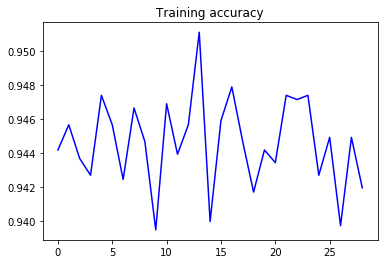

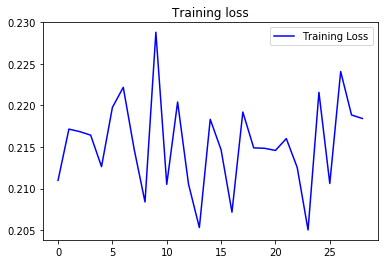

In [24]:
acc = history.history['acc']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Generating fake comments

To generate fake tweets, we use the below architecture:

![](imgs/text_gen.png)

The idea is to give one or more starting token(s) to our model, and generate the next tokens until we generate `.`.

At each step, we select the token with the highest probability as our next token and generate the next one similartly using `model.predict_classes()`. 

**Note:** The model takes as input the activation `a` from the previous state of the LSTM and the token chosen, forward propagate by one step, and get a new output activation `a`. The new activation `a` can then be used to generate the output, using the `dense` layer with `softmax` activation as before. 



**Task 2**: Implement `generate()`. 

***

In [28]:
# load best saved model
def tf_load_saved_best_model():
	"""
	Output:
		Returns best performing model saved
	"""
	return load_model(MODEL_SAVE_FILE_PATH)

model = tf_load_saved_best_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
#TASK 2
# Implement the generate() function

def generate(seed_text):
    ### START CODE HERE ###
    # converting text to list of tokens
    next_predicted_token = ''
    predicted_sentence_token_list = seed_text.split(' ')
    
    while next_predicted_token!='.':    # stopping criterion
        # word tokenization
        seed_token = tokenizer.texts_to_sequences([seed_text])[0]
        # padding to max length
        seed_token_padded = np.array(pad_sequences([seed_token], maxlen=max_sequence_len, padding='pre'))
        # token with highest probability
        predicted_token_idx = model.predict_classes(seed_token_padded)[0]  # next predicted token
        # get token from index
        next_predicted_token = reverse_word_map[predicted_token_idx]
        # add token to existing list of tokens
        predicted_sentence_token_list.append(next_predicted_token)
        # merging tokens to generate sentence
        predicted_sentence = ' '.join(predicted_sentence_token_list)
        seed_text = predicted_sentence
    return predicted_sentence
    ### END CODE HERE ### 


**Let's test it:**

In [30]:
print(generate("COVID19 virus"))
print(generate("COVID19 is the"))
print(generate("The usa is"))
print(generate("The new virus"))
print(generate("China has"))


COVID19 virus survives on surfaces for 7 days .
COVID19 is the deadliest virus known to humans .
The usa is a fever — indefinitely .
The new virus test was a bad test .
China has to protect people against the covid19 disease .


**Let's test it in an interactive mode:**

In [32]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: Covid19
Covid19 is just the damn flu . 

# Generating text by sampling

The previous part is generating text by choosing the token with the highest probability. Now, we will generate text by sampling as shown in the architecture below:

![](imgs/text_gen_sample.png)


**TASK 3:** Implement the `generate_sample()` function. To sample a token from the output at each timestep, you need to use the following two functions:
- `model.predict_proba()`: To get probabilities from the output layer.
- `np.random.choice()`: To sample from the token list using the probaility array of each token.

***

In [33]:
#TASK 3
# Implement the generate_sample() function
MAX_NUMBER_OF_RANDOM_TOKENS = 20
def generate_sample(seed_text):
   ### START CODE HERE ### 
   # converting text to list of tokens
    next_predicted_token = ''
    predicted_sentence_token_list = seed_text.split(' ')
    random_token_count = 0
    while next_predicted_token!='.' and random_token_count<=MAX_NUMBER_OF_RANDOM_TOKENS:    # stopping criterion
        # word tokenization
        seed_token = tokenizer.texts_to_sequences([seed_text])[0]
        # padding to max length
        seed_token_padded = np.array(pad_sequences([seed_token], maxlen=max_sequence_len, padding='pre'))
        # token with highest probability
        predicted_token_prob_dist = model.predict_proba(seed_token_padded)[0]  # next predicted token probability distribution
        # get random token sample from probability distribution
        sampled_token_probability = np.random.choice(predicted_token_prob_dist)
        sampled_token_idx = np.where(predicted_token_prob_dist==sampled_token_probability)[0][0]
        # get token from index
        next_sampled_token = reverse_word_map[sampled_token_idx]
        # add token to existing list of tokens
        predicted_sentence_token_list.append(next_sampled_token)
        # merging tokens to generate sentence
        predicted_sentence = ' '.join(predicted_sentence_token_list)
        seed_text = predicted_sentence
        random_token_count += 1
    # adding a fullstop at last if not present for end of sentence.
    if predicted_sentence[-1]!='.':
        predicted_sentence = predicted_sentence+'.'
    return predicted_sentence
    ### END CODE HERE ### 

In [34]:
print(generate_sample("COVID19 virus"))

COVID19 virus jail you power ? during tune may virus yourself positive help doused required akira' vegetable enter 2008 flushes were 16 on.


**Let's test it in an interactive mode:**

In [35]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate_sample(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: Covid19
Covid19 national foundation minutes full reported main south proliferation wall apology through hard exception o'mara triggering founder laurent instead stop sesame 2004. 

# Congratulations!

You've come to the end of this assignment, and have seen how to build a deep learning architecture that generate fake tweets/comments. 

Congratulations on finishing this notebook! 

